# About
    
This file downloads data from ACLED and FSNAU (prices + EW-EA dashboard) and stores it in `data/raw/ew_ea`.<br>
Then, it cleans this and the PRMN data and stores the clean datasets in `data/clean`.<br>
In order to run this file each month, you must:  
1. Update the dates in the "PARAMETERS TO SET" section
2. Upload the new PRMN data from the local desktop

**Data overview:**

Data type | Source | Notes
---|---|---
Conflict data | [ACLED](https://www.acleddata.com/wp-content/uploads/dlm_uploads/2017/10/API-User-Guide-11.pdf) |
Market prices | [FSNAU](http://www.fsnau.org/ids/index.php) | Helpful: https://stockrt.github.io/p/emulating-a-browser-in-python-with-mechanize/
Environment and health | [EW-EA dashboard](http://dashboard.fsnau.org/) | Rainfall, NDVI, river levels, cholera cases
Historical displacement | [UNHCR PRMN](https://unhcr.github.io/dataviz-somalia-prmn/index.html) | data on arrivals' previous, current, and future regions
Distances | imputed manually | data on geographic distance

ToDo:

- [ ] Could add other prices in FSNAU   
- [ ] Could dig into ACLED conflict types <- particularly the conflict actor   
- [ ] Could include reasons leaving from PRMN   
- [ ] Bring in FutureRegion   
- [ ] Confirm that distances are in meters  

For the graph: left = generate more than receive, right = receive more than generate

In [1]:
import missingno as msno
import networkx as nx
import urllib.request, json 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib.request, json
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import geopandas as gp
import mechanize
import time
from io import StringIO
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
import http.cookiejar as cookielib
%matplotlib inline

import jetson_configs as cfg

from src.get_data.get_acled import *
from src.get_data.get_ew_ea import *
from src.get_data.get_fsnau import *
from src.get_data.get_distances import *
from src.get_data.get_gis import *

from src.compile_data.compile_ew_ea import *
from src.compile_data.compile_fsnau import *
from src.compile_data.compile_distances import *
from src.compile_data.compile_acled import *

## PARAMETERS TO SET

In [2]:
data_dir = 'data/clean'

In [3]:
min_date = '2010-01'
max_date = cfg.current_month

# Credentials for FSNAU site
fsnau_user = cfg.fsnau_user
fsnau_pass = cfg.fsnau_pass

# Credentials for early-warning early-action dashboard
ew_ea_user = cfg.ew_ea_user
ew_ea_pass = cfg.ew_ea_pass

## Get all the data
Pull the data from the web.

In [4]:
# Data that needs to be downloaded only once
get_gis_all(      redownload=False)
get_distances_all(redownload=False)

In [5]:
# Data that needs to be downloaded monthly
# Careful: need to redownload last date if downloaded mid-month !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
get_acled_all(       min_date, max_date, redownload=False) 
get_fsnau_all(       min_date, max_date, fsnau_user, fsnau_pass, redownload=False)
get_ew_ea_all(       min_date, max_date, ew_ea_user, ew_ea_pass, redownload=False)
get_ew_ea_rivers_all(min_date, max_date, ew_ea_user, ew_ea_pass, redownload=False)

The following files were downloaded: ['2019-11']
The following files were downloaded: ['2019-11']
The following files were downloaded: ['2019-11']
The following files were downloaded: ['2019-11']


## Clean all the data
Clean the data and sturcture into datasets.

In [6]:
source_dir = "data/raw/ew_ea"
target_dir = "data/clean"

In [7]:
compile_acled()
compile_fsnau()
compile_ew_ea()
compile_ew_ea_rivers()
compile_distances()

# PRMN compiled locally

## Quick inspection

In [8]:
acled = pd.read_csv(f"{data_dir}/acled_admin1.csv", index_col=['region', 'date'])
prmn  = pd.read_csv(f"{data_dir}/prmn_admin1.csv",  index_col=['region', 'date'])
fsnau = pd.read_csv(f"{data_dir}/fsnau_admin1.csv", index_col=['region', 'date'])
ew_ea = pd.read_csv(f"{data_dir}/ew_ea_admin1.csv", index_col=['region', 'date'],
                   usecols=['awd_cholera_deaths', 
                            'awd_cholera_cases',
                            'malaria_cases', 
                            'measles_cases', 
                            'new_admissions_gam',
                            'rainfall', 
                            'vegetation_cover_ndvi',
                            'region',
                            'date'])

ew_ea_rivers = pd.read_csv(f"{data_dir}/ew_ea_rivers.csv",     index_col=['date'])
distances    = pd.read_csv(f"{data_dir}/distances_admin1.csv", index_col=['region'])

### EW-EA

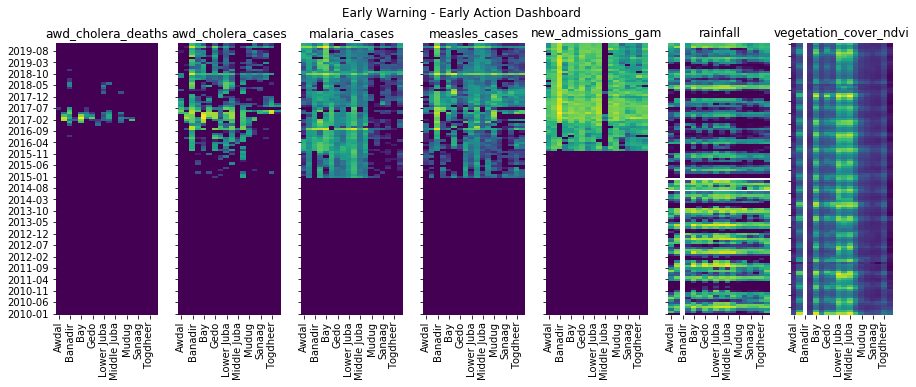

In [9]:
fig, ax = plt.subplots(1,7, figsize=[15,5], sharey=True)

n=0
for c in ew_ea.columns:
    
    sns.heatmap(np.log(1+ew_ea[c].unstack(level='region')), cbar=None, ax=ax[n], cmap='viridis')
    
    ax[n].set_xlabel("")
    ax[n].set_ylabel("")
    ax[n].set_title(c)
    
    n+=1
    
fig.suptitle("Early Warning - Early Action Dashboard")
plt.savefig("figures/missing/ew_ea.png", dpi=100, bbox_inches="tight")

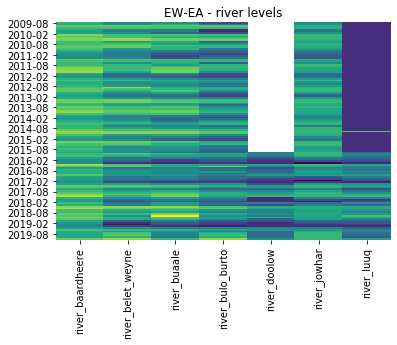

In [10]:
fig, ax = plt.subplots(1,1)

sns.heatmap(np.log(1+ew_ea_rivers), cbar=None, ax=ax, cmap='viridis')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("EW-EA - river levels")
plt.savefig("figures/missing/ew_ea_rivers.png", dpi=100, bbox_inches="tight")

### FSNAU

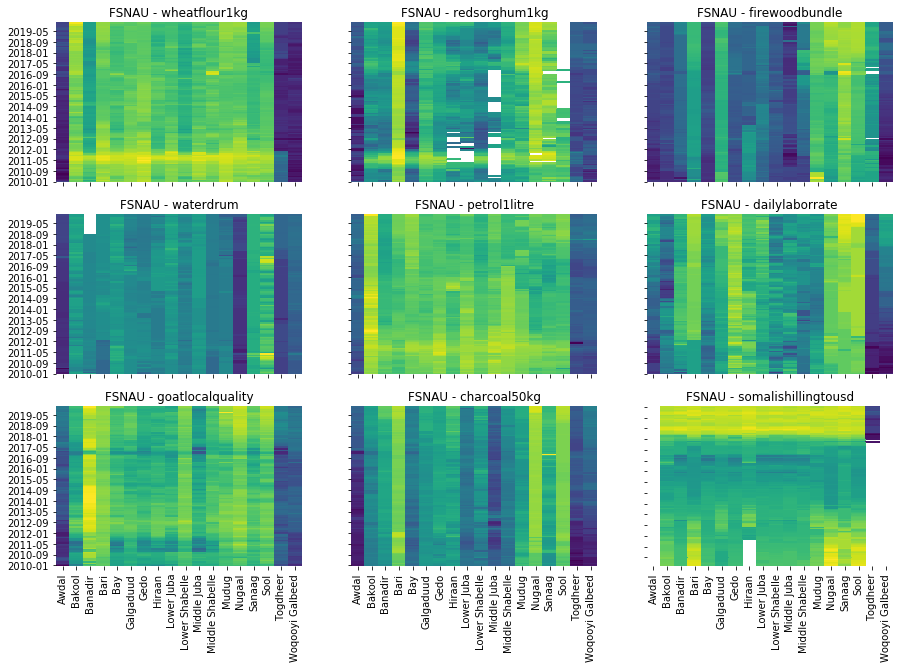

In [11]:
fig, ax = plt.subplots(3,3, figsize=[15,10], sharey=True, sharex=True)

n=0
for c in fsnau.columns:
    
    i = n%3
    j = n//3

    sns.heatmap(np.log(1+fsnau[c].unstack(level='region')), cbar=None, ax=ax[i][j], cmap='viridis')
    
    ax[i][j].set_title("FSNAU - " + c)
    ax[i][j].set_xlabel("")
    ax[i][j].set_ylabel("")
    
    n+=1

plt.savefig("figures/missing/fsnau.png", dpi=100, bbox_inches="tight")

### ACLED

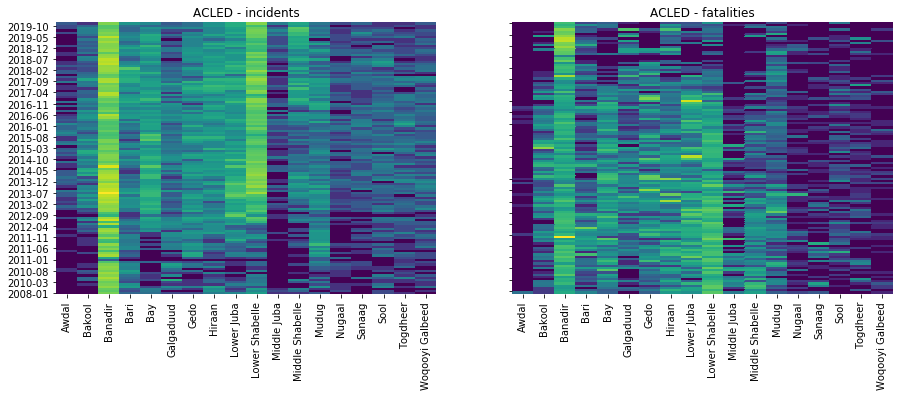

In [15]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

n=0
for c in acled.columns:
    

    sns.heatmap(np.log(1+acled[c].unstack(level='region')), cbar=None, ax=ax[n], cmap='viridis')
    
    ax[n].set_xlabel("")
    ax[n].set_ylabel("")
    ax[n].set_title("ACLED - " + c)
    
    n+=1

plt.savefig("figures/missing/acled.png", dpi=100, bbox_inches="tight")

### PRMN

In [12]:
# Add a column with ratio of arrivals to departures 
prmn['ratio'] = 1+prmn.arrivals/1+prmn.departures

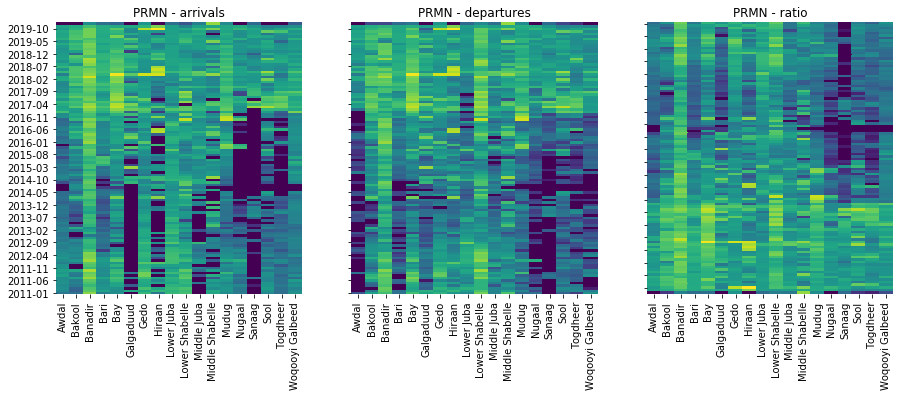

In [13]:
fig, ax = plt.subplots(1,3, figsize=[15,5], sharey=True)

n=0
for c in prmn.columns:
    
    sns.heatmap(np.log(1+prmn[c].unstack(level='region')), cbar=None, 
                ax=ax[n], cmap='viridis')
    
    ax[n].set_xlabel("")
    ax[n].set_ylabel("")
    ax[n].set_title("PRMN - " + c)
    
    n+=1

plt.savefig("figures/missing/prmn.png", dpi=100, bbox_inches="tight")